In [1]:
import os
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D  

# our Python Scripts
import cosmology.weaklensing as wl
import cosmology.spectrumcalc as sc
import utils.common as uc
import utils.helpers as hp
import settings as st

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (8, 8)
fontSize = 20

### Basic Setting

In [2]:
# par = {'omega_cdm': 0.1295, 'omega_b': 0.0224, 'ln10^{10}A_s': 2.895, 'n_s': 0.9948, 'h': 0.7411}
par = {'omega_cdm': 0.12, 'omega_b': 0.022, 'ln10^{10}A_s': 2.9, 'n_s': 1.0, 'h': 0.75}

# redshift index [0:99]
index = 0

# choose if we want to save all figures
save_fig = False

#### Function to Plot the Gradient

In [3]:
def plot_gradient(grad_gp, grad_class, wn, z_index=0, p_index=0, save=False):
    plt.figure(figsize=(8,8))
    plt.plot(wn, grad_class[str(p_index)][z_index], lw = 3, c = 'r', label = 'CLASS')
    plt.plot(wn, grad_gp[str(p_index)][z_index], lw = 3, c = 'skyblue', label = 'GP', linestyle = '--')
    plt.ylabel(r'$\frac{\partial P_{\delta}(k,z)}{\partial\theta_{i}}$', fontsize = fontSize)
    plt.xlabel(r'$k\,[h\,\textrm{Mpc}^{-1}]$', fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
    plt.xlim(min(wn), max(wn))
    plt.xscale('log')
    if save:
        plt.savefig('plots/grad_'+str(p_index)+'.pdf', bbox_inches = 'tight')
    plt.show()

### Testing Matter Power Spectrum Predictions

Emulator is a function of the following 5 parameters (to add neutrino):

<!-- \Sigma m_{\nu} -->

$$\left[\Omega_{\textrm{cdm}}h^{2},\Omega_{\textrm{b}}h^{2},\textrm{ln}(10^{10})A_{s},n_{s},h\right]$$

#### Include Baryon Feedback (Optional)

$$P_{\delta}^{\textrm{mod}}(k,z)=b^{2}(k,z)P_{\delta}(k,z)$$

$$b^{2}(k,z)=1-A_{\textrm{bary}}\left[A_{z}e^{(B_{z}x-C_{z})^{3}}-D_{z}x e^{E_{z}x}\right]$$

where $k = \textrm{log}_{10}(k/\textrm{Mpc}^{-1})$. Therefore, if $A_{\textrm{bary}}=0$, this implies no baryon feedback. Can be switched off by using a $\delta$ prior (near 0) in the inference engine. 

<u>Gradient</u> ($A_{\textrm{bary}}$)

Define $f(k,z)=A_{z}e^{(B_{z}x-C_{z})^{3}}-D_{z}x e^{E_{z}x}$.

$$\dfrac{\partial P_{\delta}^{\textrm{mod}}}{\partial A_{\textrm{bary}}}=-f(k,z)P_{\delta}(k,z)$$

<u>Gradient and Second Derivatives</u> (cosmological parameters)

$$
P_{\delta}(k,z;\boldsymbol{\theta}) = A(z;\boldsymbol{\theta})\left[1+q(k,z;\boldsymbol{\theta})\right]P_{\textrm{lin}}(k,z_{0};\boldsymbol{\theta})
$$

$$
\dfrac{\partial P_{\delta}}{\partial\boldsymbol{\theta}}=\dfrac{\partial A}{\partial\boldsymbol{\theta}}(1+q)P_{\textrm{lin}}+A\dfrac{\partial q}{\partial\boldsymbol{\theta}}P_{\textrm{lin}}+A(1+q)\dfrac{P_{\textrm{lin}}}{\partial\boldsymbol{\theta}}
$$

$$
\begin{split}
\dfrac{\partial^{2} P_{\delta}}{\partial\boldsymbol{\theta}^{2}} &= \dfrac{\partial^{2} A}{\partial \boldsymbol{\theta}^{2}}(1+q)P_{\textrm{lin}}+A\dfrac{\partial^{2} q}{\partial\boldsymbol{\theta}^{2}}P_{\textrm{lin}}+A(1+q)\dfrac{\partial^{2}P_{\textrm{lin}}}{\partial\boldsymbol{\theta}^{2}}\\
&+2\dfrac{\partial A}{\partial \boldsymbol{\theta}}\dfrac{\partial q}{\partial \boldsymbol{\theta}}P_{\textrm{lin}}+2\dfrac{\partial A}{\partial\boldsymbol{\theta}}(1+q)\dfrac{\partial P_{\textrm{lin}}}{\partial\boldsymbol{\theta}}+2A\dfrac{\partial q}{\partial\boldsymbol{\theta}}\dfrac{\partial P_{\textrm{lin}}}{\partial \boldsymbol{\theta}}
\end{split}
$$

### Using 3 Components

Change setting file, that is, 
```python
components = True
```

#### GP

In [4]:
# GPs
gp_model = sc.matterspectrum(emulator=True)

# additional line to load all the GPs (no need for this if emulator=False - falls back to CLASS)
gp_model.load_gps(directory='semigps')

In [5]:
# gradient of non-linear matter power spectrum (GPs)
pk_gp_grad = gp_model.int_grad_pk_nl(par, order = 1)

In [6]:
# non-linear matter power spectrum (GP)
gf, pk_nl, pk_l = gp_model.int_pk_nl(par, a_bary=0)

In [7]:
# non-linear matter power spectrum (GP) - with baryon feedback (applies only to non-linear Pk)
_, pk_nl_bar, _ = gp_model.int_pk_nl(par, a_bary=1)

#### CLASS

In [8]:
# CLASS
class_model = sc.matterspectrum(emulator=False)

In [9]:
# gradient of non-linear matter power spectrum

epsilon = [1E-3, 1E-4, 1E-3, 1E-3, 1E-2]

pk_class_grad = class_model.int_grad_pk_nl(par, order = 1, eps = epsilon)

In [10]:
# non-linear matter power spectrum (CLASS)
gf_class, pk_class, pl_class = class_model.int_pk_nl(par, a_bary = 0)

# non-linear matter power spectrum (CLASS) - with Baryon feedback (applies only to non-linear Pk)
_, pk_class_bar, _ = class_model.int_pk_nl(par, a_bary = 1)

#### Plots (Power Spectra)

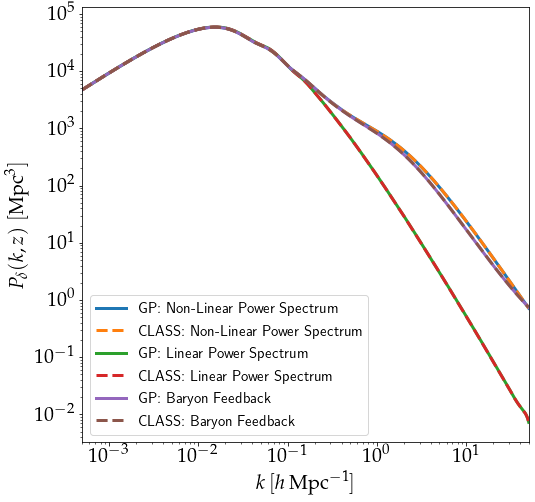

In [11]:
plt.figure(figsize = (8,8))
plt.loglog(gp_model.k_new, pk_nl[:,index], label = 'GP: Non-Linear Power Spectrum', lw = 3)
plt.loglog(class_model.k_new, pk_class[:,index], label = 'CLASS: Non-Linear Power Spectrum', lw = 3, linestyle = '--')
plt.loglog(gp_model.k_new, pk_l,label = 'GP: Linear Power Spectrum', lw = 3)
plt.loglog(class_model.k_new, pl_class,label = 'CLASS: Linear Power Spectrum', lw = 3, linestyle = '--')
plt.loglog(gp_model.k_new, pk_nl_bar[:,index], label = 'GP: Baryon Feedback', lw = 3)
plt.loglog(class_model.k_new, pk_class_bar[:,index], label = 'CLASS: Baryon Feedback', lw = 3, linestyle='--')
plt.ylabel(r'$P_{\delta}(k,z)\;[\textrm{Mpc}^{3}]$', fontsize = fontSize)
plt.xlabel(r'$k\,[h\,\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.xlim(min(gp_model.k_new), max(gp_model.k_new))
if save_fig:
    plt.savefig('plots/pk_nl_gp_class.pdf', bbox_inches = 'tight')
plt.show()

#### Plot (Growth Factor)

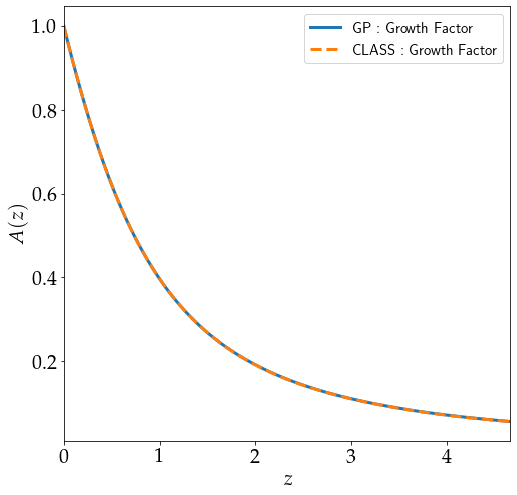

In [12]:
plt.figure(figsize = (8,8))
plt.plot(gp_model.z_new, gf, lw = 3, label = 'GP : Growth Factor')
plt.plot(class_model.z_new, gf_class, lw = 3, label = 'CLASS : Growth Factor', linestyle = '--')
plt.ylabel(r'$A(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(gp_model.z_new), max(gp_model.z_new))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
if save_fig:
    plt.savefig('plots/gf_gp_class.pdf', bbox_inches = 'tight')
plt.show()

#### Plots (Gradient)

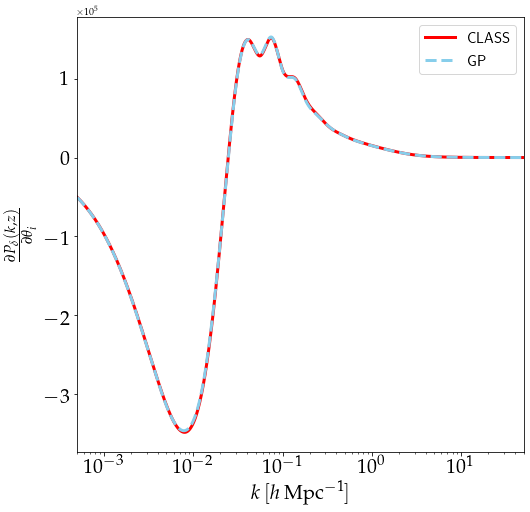

In [13]:
plot_gradient(pk_gp_grad, pk_class_grad, class_model.k_new, z_index=0, p_index=0, save = save_fig)

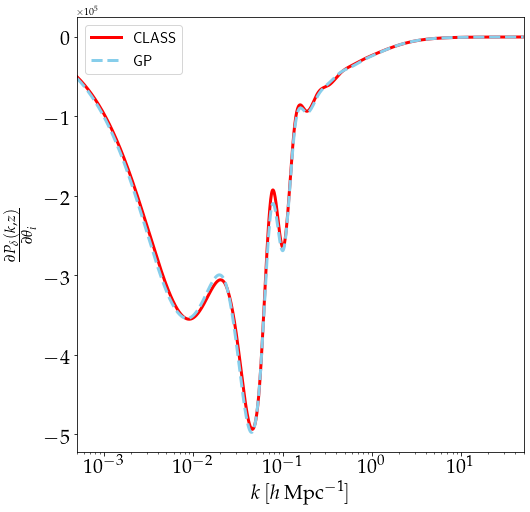

In [14]:
plot_gradient(pk_gp_grad, pk_class_grad, class_model.k_new, z_index=0, p_index=1, save = save_fig)

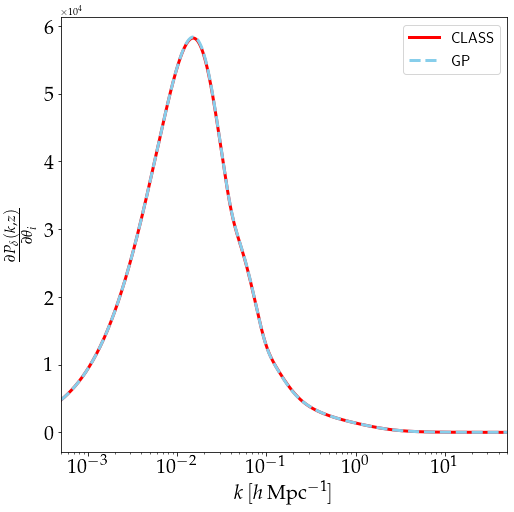

In [15]:
plot_gradient(pk_gp_grad, pk_class_grad, class_model.k_new, z_index=0, p_index=2, save = save_fig)

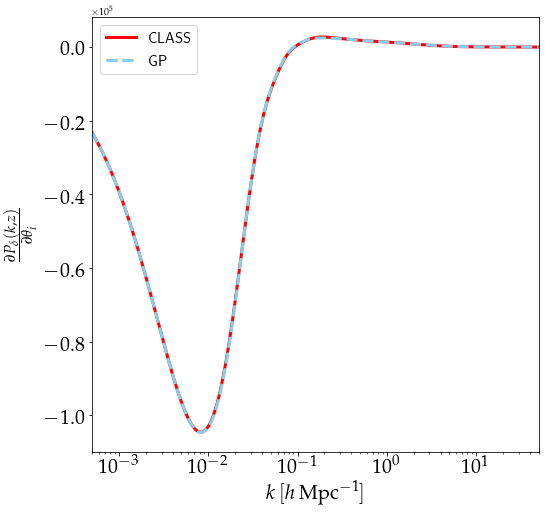

In [16]:
plot_gradient(pk_gp_grad, pk_class_grad, class_model.k_new, z_index=0, p_index=3, save = save_fig)

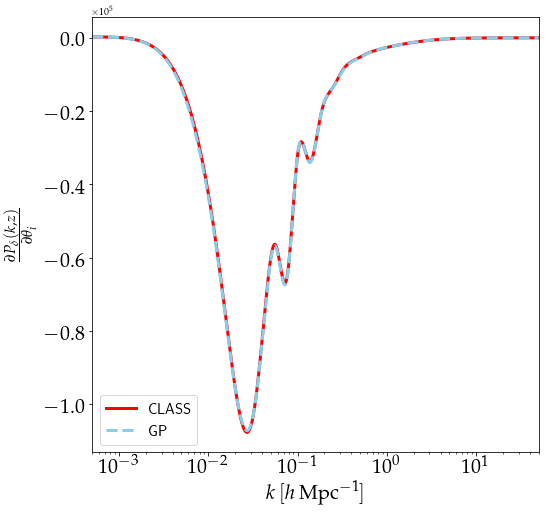

In [17]:
plot_gradient(pk_gp_grad, pk_class_grad, class_model.k_new, z_index=0, p_index=4, save = save_fig)

### All Gradient Plots in a Single Plot

In [18]:
from matplotlib.lines import Line2D
lines = [Line2D([0], [0], color='r', linewidth=3, linestyle='-'), Line2D([0], [0], color='skyblue', linewidth=3, linestyle='--') ]
labels = ['CLASS', 'GP']

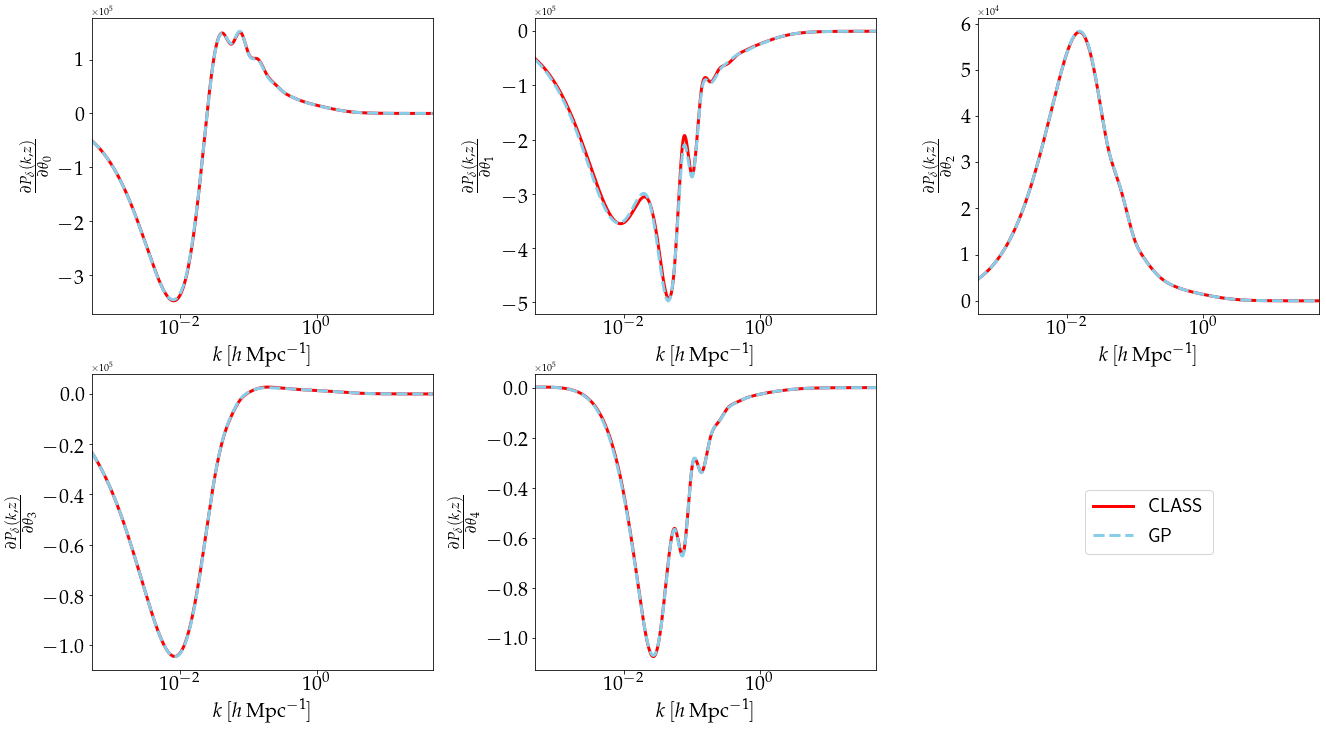

In [19]:
z_index = 0
# plt.figure(figsize = (18, 12))
fig, ax = plt.subplots(figsize = (22, 12), nrows=2, ncols=3)

index = 0
k_new = class_model.k_new

for i in range(2):
    for j in range(3):
        if (j!=2 or i!=1):
            ax[i,j].plot(k_new, pk_class_grad[str(index)][z_index], lw = 3, c = 'r', label = 'CLASS')
            ax[i,j].plot(k_new, pk_gp_grad[str(index)][z_index], lw = 3, c = 'skyblue', label = 'GP', linestyle = '--')
            ax[i,j].set_ylabel(r'$\frac{\partial P_{\delta}(k,z)}{\partial\theta_{'+str(index)+'}}$', fontsize = fontSize)
            ax[i,j].set_xlabel(r'$k\,[h\,\textrm{Mpc}^{-1}]$', fontsize = fontSize)
            ax[i,j].tick_params(axis='x', labelsize=fontSize)
            ax[i,j].tick_params(axis='y', labelsize=fontSize)
            ax[i,j].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            ax[i,j].set_xlim(min(k_new), max(k_new))
            ax[i,j].set_xscale('log')
        else:
            ax[i,j].axis('off')
            ax[i,j].legend(lines, labels, loc = 'center',prop={'family':'sans-serif', 'size':20})
        index +=1

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=None)
if save_fig:
    plt.savefig('plots/all_gradients.pdf', bbox_inches = 'tight')
plt.show()

### Calculating the Weak Lensing Power Spectra

In [20]:
lensing_class = wl.spectra(emu=False)
lensing_gp = wl.spectra(emu=True, dir_gp='semigps')

In [21]:
# centres of the distribution
zcenter = [0.50, 0.75]

# distribution range
dr = {'zmin': 0.0, 'zmax': 2.0, 'nzmax': 200}

# distribution properties
dp = {'sigma': [0.1, 0.2]}

nz = lensing_class.n_of_z(zcenter, model_name='gaussian', dist_prop=dp, dist_range=dr)

# similar to above
_ = lensing_gp.n_of_z(zcenter, model_name='gaussian', dist_prop=dp, dist_range=dr)

### Plot the $n(z)$ Used Here

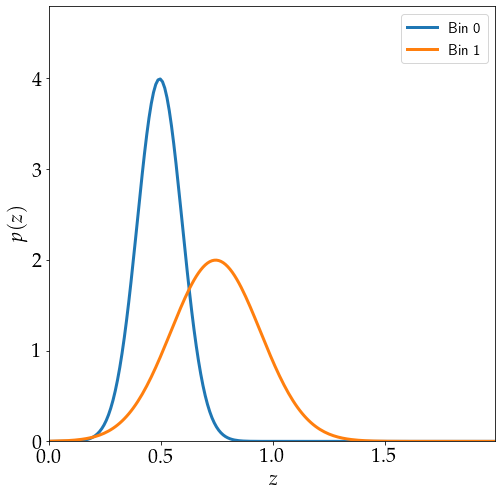

In [22]:
plt.figure(figsize=(8, 8))
plt.plot(nz['z'], nz['h0'], lw = 3, label = 'Bin 0')
plt.plot(nz['z'], nz['h1'], lw = 3, label = 'Bin 1')
plt.ylabel(r'$p(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.ylim(0.0, 1.2*max(max(nz['h0']), max(nz['h1'])))
plt.xlim(min(nz['z']), max(nz['z']))
if save_fig:
    plt.savefig('plots/nz.pdf', bbox_inches = 'tight')
plt.show()

In [23]:
cl_class = lensing_class.wl_power_spec(par, a_bary=1.0)

In [24]:
cl_gp = lensing_gp.wl_power_spec(par, a_bary=1.0)

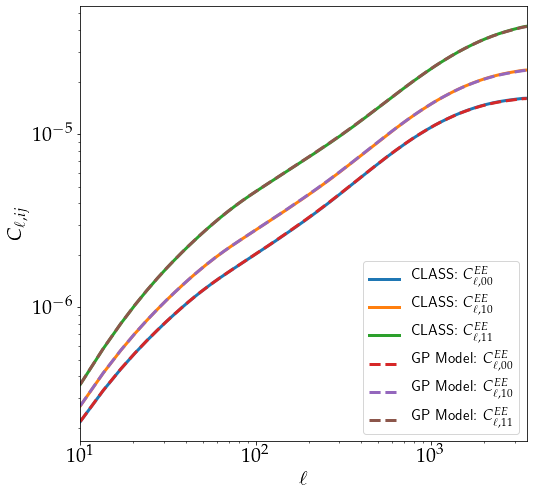

In [25]:
ells = lensing_class.ells_sum

plt.figure(figsize = (8,8))
plt.loglog(ells, cl_class[0]['00'], lw = 3, label = r'CLASS: $C_{\ell,00}^{EE}$', linestyle = '-')
plt.loglog(ells, cl_class[0]['10'], lw = 3, label = r'CLASS: $C_{\ell,10}^{EE}$', linestyle = '-')
plt.loglog(ells, cl_class[0]['11'], lw = 3, label = r'CLASS: $C_{\ell,11}^{EE}$', linestyle = '-')

plt.loglog(ells, cl_gp[0]['00'], lw = 3, label = r'GP Model: $C_{\ell,00}^{EE}$', linestyle = '--')
plt.loglog(ells, cl_gp[0]['10'], lw = 3, label = r'GP Model: $C_{\ell,10}^{EE}$', linestyle = '--')
plt.loglog(ells, cl_gp[0]['11'], lw = 3, label = r'GP Model: $C_{\ell,11}^{EE}$', linestyle = '--')

plt.ylabel(r'$C_{\ell,ij}$', fontsize = fontSize)
plt.xlabel(r'$\ell$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'lower right',prop={'family':'sans-serif', 'size':15})
plt.xlim(min(ells), max(ells))
if save_fig:
    plt.savefig('plots/cl_ee_gp_class.pdf', bbox_inches = 'tight')
plt.show()

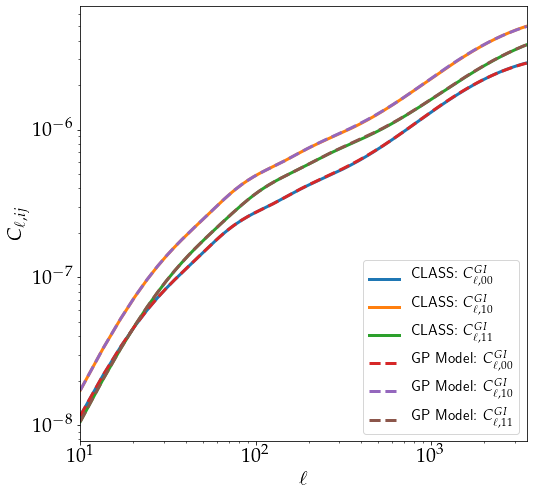

In [26]:
plt.figure(figsize = (8,8))

plt.loglog(ells, cl_class[1]['00'], lw = 3, label = r'CLASS: $C_{\ell,00}^{GI}$', linestyle = '-')
plt.loglog(ells, cl_class[1]['10'], lw = 3, label = r'CLASS: $C_{\ell,10}^{GI}$', linestyle = '-')
plt.loglog(ells, cl_class[1]['11'], lw = 3, label = r'CLASS: $C_{\ell,11}^{GI}$', linestyle = '-')

plt.loglog(ells, cl_gp[1]['00'], lw = 3, label = r'GP Model: $C_{\ell,00}^{GI}$', linestyle = '--')
plt.loglog(ells, cl_gp[1]['10'], lw = 3, label = r'GP Model: $C_{\ell,10}^{GI}$', linestyle = '--')
plt.loglog(ells, cl_gp[1]['11'], lw = 3, label = r'GP Model: $C_{\ell,11}^{GI}$', linestyle = '--')

plt.ylabel(r'$C_{\ell,ij}$', fontsize = fontSize)
plt.xlabel(r'$\ell$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'lower right',prop={'family':'sans-serif', 'size':15})
plt.xlim(min(ells), max(ells))
if save_fig:
    plt.savefig('plots/cl_gi_gp_class.pdf', bbox_inches = 'tight')
plt.show()

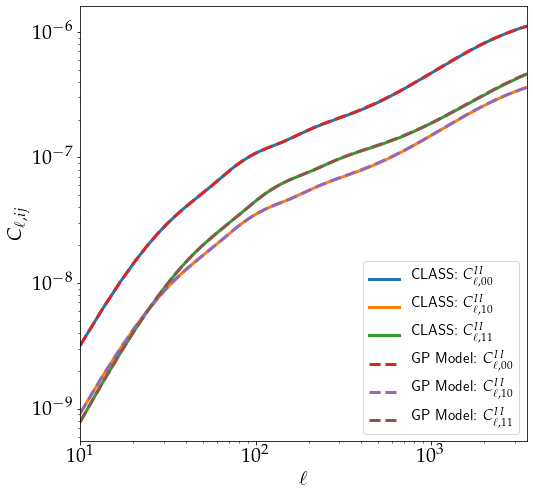

In [27]:
plt.figure(figsize = (8,8))

plt.loglog(ells, cl_class[2]['00'], lw = 3, label = r'CLASS: $C_{\ell,00}^{II}$', linestyle = '-')
plt.loglog(ells, cl_class[2]['10'], lw = 3, label = r'CLASS: $C_{\ell,10}^{II}$', linestyle = '-')
plt.loglog(ells, cl_class[2]['11'], lw = 3, label = r'CLASS: $C_{\ell,11}^{II}$', linestyle = '-')

plt.loglog(ells, cl_gp[2]['00'], lw = 3, label = r'GP Model: $C_{\ell,00}^{II}$', linestyle = '--')
plt.loglog(ells, cl_gp[2]['10'], lw = 3, label = r'GP Model: $C_{\ell,10}^{II}$', linestyle = '--')
plt.loglog(ells, cl_gp[2]['11'], lw = 3, label = r'GP Model: $C_{\ell,11}^{II}$', linestyle = '--')

plt.ylabel(r'$C_{\ell,ij}$', fontsize = fontSize)
plt.xlabel(r'$\ell$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'lower right',prop={'family':'sans-serif', 'size':15})
plt.xlim(min(ells), max(ells))

if save_fig:
    plt.savefig('plots/cl_ii_gp_class.pdf', bbox_inches = 'tight')
    
plt.show()

### Plot a 3D version of the Matter Power Spectrum

In [28]:
quant = lensing_class.pk_nonlinear_components(par)

In [29]:
z_fix = lensing_class.redshifts
k_fix = lensing_class.k_range
k_new = lensing_class.k_new
z_new = lensing_class.z_new

#### Linear Matter Power Spectrum

In [30]:
pl_int = uc.interpolate([k_fix, quant['pl'], k_new])

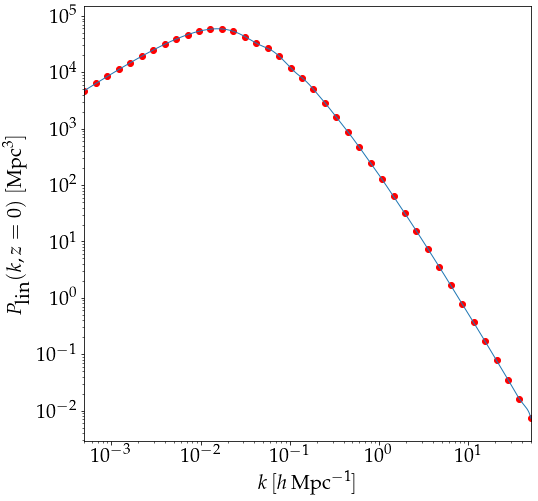

In [31]:
plt.figure(figsize=(8, 8))
plt.loglog(k_new, pl_int, lw = 1)
plt.scatter(k_fix, quant['pl'], c = 'r')
plt.ylabel(r'$P_{\textrm{lin}}(k,z=0)\;[\textrm{Mpc}^{3}]$', fontsize = fontSize)
plt.xlabel(r'$k\,[h\,\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(k_fix), max(k_fix))
if save_fig:
    plt.savefig('plots/pl.pdf', bbox_inches = 'tight')
plt.show()

#### Growth Factor

In [32]:
gf_int = uc.interpolate([z_fix, quant['gf'], z_new])

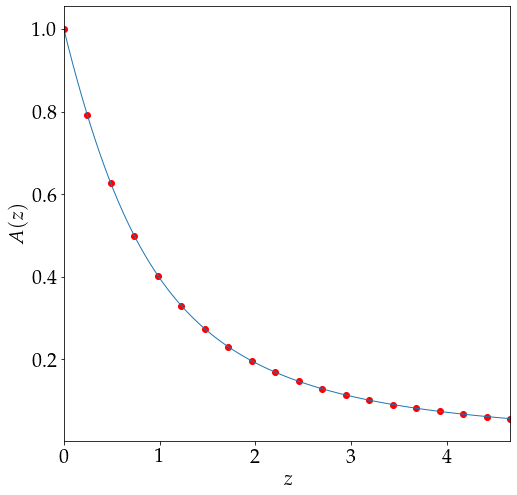

In [33]:
plt.figure(figsize=(8, 8))
plt.plot(z_new, gf_int, lw = 1)
plt.scatter(z_fix, quant['gf'], c = 'r')
plt.ylabel(r'$A(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(z_fix), max(z_fix))
if save_fig:
    plt.savefig('plots/gf.pdf', bbox_inches = 'tight')
plt.show()

#### $q$ function

In [34]:
X, Y = np.meshgrid(k_fix, z_fix)

qf = 1.0 + quant['qf']

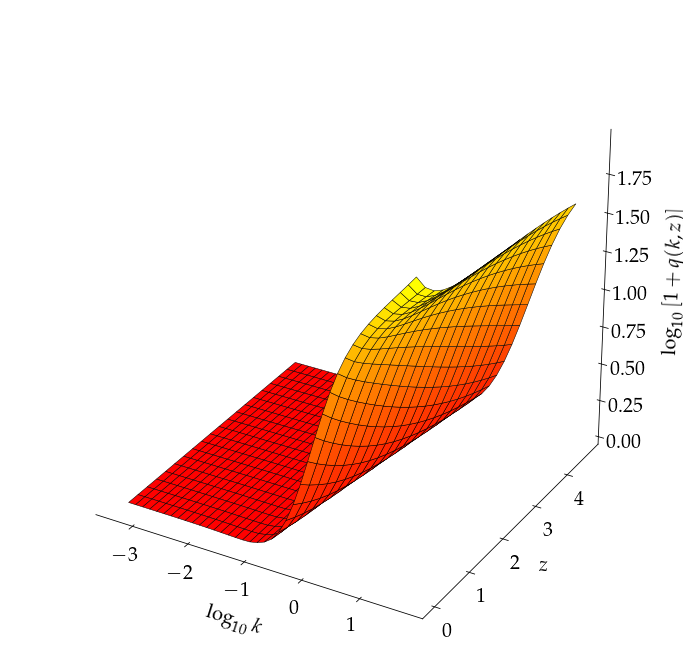

In [35]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np.log10(X), Y, np.log10(qf.T), linewidth=0.5, edgecolors='k', cmap=plt.cm.autumn)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.tick_params(axis='z', which='major', labelsize=fontSize, pad = 10)
ax.tick_params(axis='y', which='major', labelsize=fontSize, pad = 5)
ax.tick_params(axis='x', which='major', labelsize=fontSize, pad = 5)

ax.set_xlabel(r'$\textrm{log}_{10\;}k$', fontsize = fontSize, labelpad=20)
ax.set_ylabel(r'$z$', fontsize = fontSize, labelpad=10)
ax.set_zlabel(r'$\textrm{log}_{10\;}[1+q(k,z)]$', fontsize = fontSize, labelpad=30)
if save_fig:
    plt.savefig('plots/3D_qf.pdf', bbox_inches = 'tight')
plt.show()

#### 3D Matter Power Spectrum

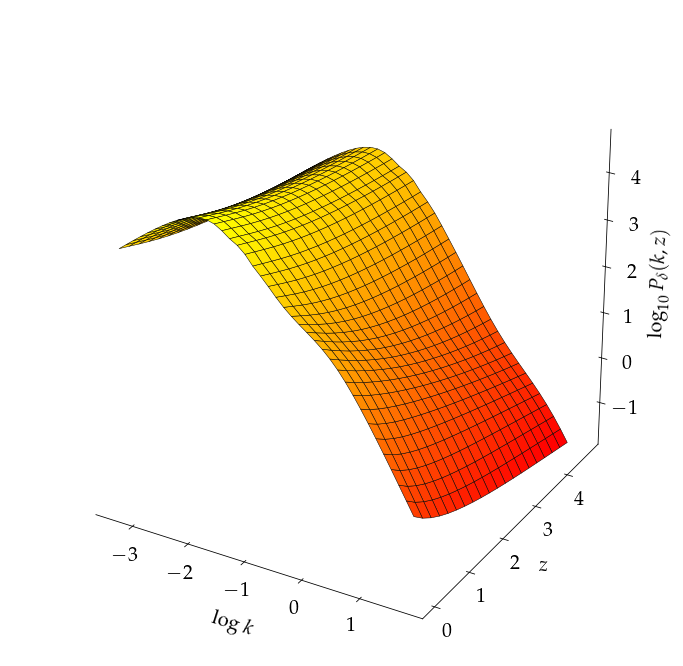

In [36]:
pk = quant['pk']

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np.log10(X), Y, np.log10(pk.T), linewidth=0.5, edgecolors='k', cmap=plt.cm.autumn)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.tick_params(axis='z', which='major', labelsize=fontSize, pad = 10)
ax.tick_params(axis='y', which='major', labelsize=fontSize, pad = 5)
ax.tick_params(axis='x', which='major', labelsize=fontSize, pad = 5)

ax.set_xlabel(r'$\textrm{log }k$', fontsize = fontSize, labelpad=20)
ax.set_ylabel(r'$z$', fontsize = fontSize, labelpad=10)
ax.set_zlabel(r'$\textrm{log}_{10\;}P_{\delta}(k,z)$', fontsize = fontSize, labelpad=20)
if save_fig:
    plt.savefig('plots/3D_pk.pdf', bbox_inches = 'tight')
plt.show()